# Linear Systems and Signal Convolution
Lev Svalov, l.svalov@innopolis.university <br>
Shamil Hastiev, s.hastiev@innopolis.university <br>
Kazybek Askarbek, k.askarbek@innopolis.university
## Introduction


Digital Filter is a model of a physical system

# Task 1: Impulse Response and Convolution

1.1 Record IRC of some interesting place(the wild/in Kazan/Innopolis/somewhere else). Take some pictures of the place where the IRC is recorded. This will be the kernel of your FIR filter. Normalize the kernel so that the maximum value is 1.

To record an impulse response of a room we used a Dirac function sound(clap of hands).  
In the chart below, we see the waves of our clap in our chosen room.

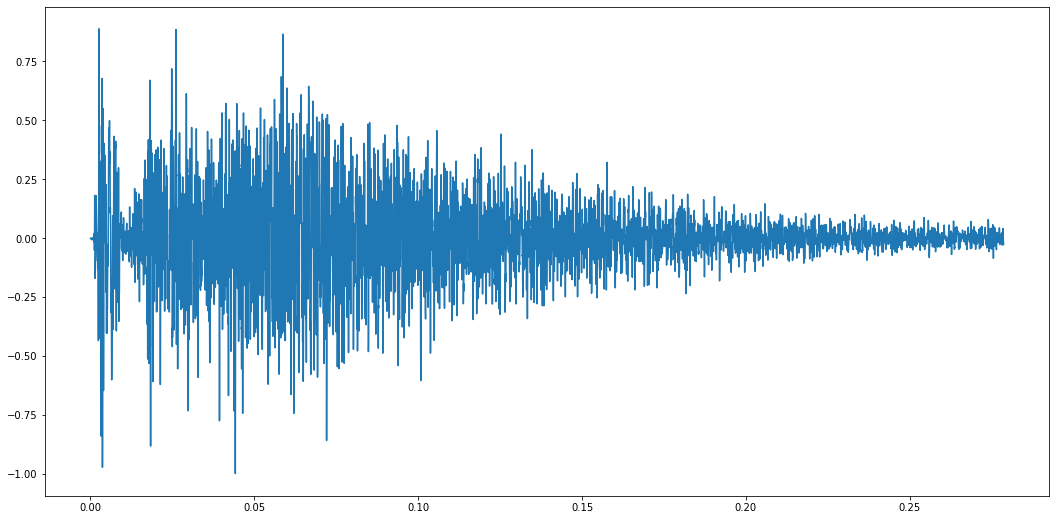

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
f_rate, signal = wavfile.read('record3.wav')

time = np.linspace(
    0, # start
    len(signal) / f_rate,
    num = len(signal)
)
signal = [s[0] for s in signal]
# normalizing 
norm = np.max(np.abs(signal))
signal = signal/norm
plt.figure(figsize=(18, 9))
plt.plot(time, signal)
plt.show()

In [2]:
from IPython.display import Audio
Audio(signal/norm, rate=f_rate)

1.2 Implement the convolution algorithm. Try to optimize its execution time. As a rule of thumb, the implementation that is vectorized (no loops) will be the fastest. You may use python's time.time()function to measure the execution time. Compare regular convolution (implement it with striding, do not use built-in convolution) and FFT based (do not use built-in FFT convolve).

We implemented three convolition algorithm approches:  
 - using standart convolution formula $c_n = \sum_{k=-\infty}^{k=\infty} x_k y_{k-n}^*$. This approche were implemented using 'for' loops and sliding window technics
 - using Circular convolution theorem ${\displaystyle \{g_{_{N}}*h\}[n]=\ {\mathcal {F}}^{-1}\{{\mathcal {F}}\{g\}\cdot {\mathcal {F}}\{h\}\}.}$

In [13]:
import time
from collections import defaultdict
audios = ['DSP_2020_A3_DATA/drums.wav',
         #'DSP_2020_A3_DATA/music_20s_8000.wav',
#          'DSP_2020_A3_DATA/speech.wav',
#          'DSP_2020_A3_DATA/violin.wav',
#          'DSP_2020_A3_DATA/voice.wav'
]

def loops(signal, kernal):
    flen =  len(signal) - len(kernal) + 1
    trans_signal = [np.dot(signal[i:i+len(kernal)], kernal[::-1]) for i in range(flen)]
    return trans_signal

def striding(signal, kernal):
    trans_signal = []
    signals = np.lib.stride_tricks.sliding_window_view(signal, len(kernal))
    for s in signals:
        trans_signal.append(np.dot(s, np.flip(kernal)))
    return trans_signal
        
def using_fft(signal, kernal):
    fflen =  len(signal) - len(kernal) + 1
    flen =  len(signal)
    ss = np.fft.fft(signal)
    flen -= int((len(signal) - len(kernal))/2) + len(kernal)
    kk =  np.zeros(int((len(signal) - len(kernal))/2))
    kk = np.append(kk, kernal)
    kk = np.append(kk, np.zeros(flen))
    kk = np.fft.fft(kk)
    new_signal = np.fft.ifft(kk * ss)
    new_signal = np.real(new_signal)
    return np.fft.fftshift(new_signal)[:fflen]
    
methods = [loops, striding, using_fft]
times = defaultdict(list)
for method in methods:
    for audio in audios:
        start = time.time()
        fs, ex_signal = wavfile.read(audio)
        try:
            ex_signal = [s[0] for s in ex_signal]
        except:
            pass
        trans_signal = method(ex_signal, signal)
        times[method.__name__].append(time.time()-start)

    

<ipython-input-13-66c7d4804ec3>:40: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, ex_signal = wavfile.read(audio)


We have tested time taken to process one of the audio files by each approche and got the following results:

In [14]:
for t in times:
    print(t, times[t])

loops [10.941039800643921]
striding [9.554332494735718]
using_fft [0.24183130264282227]


In [5]:
# here we can listen
path_to_audio = 'DSP_2020_A3_DATA/voice.wav'
method = striding
fs, ex_signal = wavfile.read(path_to_audio)
try:
    ex_signal = [s[0] for s in ex_signal]
except:
    pass
trans_signal = method(ex_signal, signal)
print(trans_signal[:10])
Audio(trans_signal, rate=fs)

<ipython-input-5-f98abe1b59ed>:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, ex_signal = wavfile.read(path_to_audio)


[594.4080946680178, 729.5563127359801, 658.1594529883057, 399.4033981029561, 132.36030021180628, -124.93070264296954, -405.10134450686076, -557.7797218896766, -504.86780550695335, -378.394833778433]


1.3 Apply the environment effect of your chosen place on your favorite track by convolving it with IRC using your custom algorithm. Also convolve the following tracks with IRC: voice.wav, violin.wav, speech.wav, and drums.wav. All files can be downloaded from the document head.  

In [11]:
audios = [ 
    'DSP_2020_A3_DATA/drums.wav',
    'DSP_2020_A3_DATA/speech.wav',
    'DSP_2020_A3_DATA/violin.wav',
    'DSP_2020_A3_DATA/voice.wav',
    'katyusha-rascvetali-yabloni-i-grushi-poplyli-tumany-nad-rekoj.vyhodila-na-bereg-katyusha-na-vysokij-bereg-na-_(get-tune.net).wav'
]

for audio in audios:
    fs, ex_signal = wavfile.read(audio)
    try:
      ex_signal = [s[0] for s in ex_signal]
    except:
        pass
    trans_signal = using_fft(ex_signal, signal)
    print(trans_signal[:10])


<ipython-input-11-32e05c5235e6>:10: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, ex_signal = wavfile.read(audio)


[-32136.33442306 -20313.11865733  -1706.39368266   7413.2164564
  -5011.70144581 -23064.54038125 -29864.45206741 -31412.02527857
 -26016.47766829 -13694.57482273]
[-219.28566166  -20.43608988  103.09881205  143.40597661  178.0675937
   90.39110415  -92.48277926 -191.67892992 -216.20849065 -284.47439912]
[-0.00099447 -0.0011984  -0.00139482 -0.00148055 -0.00152018 -0.0015636
 -0.00147006 -0.00110699 -0.0006412  -0.00034661]
[315.40616079 310.58822175 279.61580256 216.83787642 146.06911318
  63.18160052 -21.51109679 -60.31457777 -67.37369924 -74.34708537]
[ -42.43958928  -53.275716    -69.12910949  -82.06179206  -89.76963809
  -99.23667004 -110.15471038 -110.94244406 -101.56266691  -94.88336863]


1.4 Equivalence of Circular and Linear Convolution Theorem <br>
The circular convolution and linear convolution are different operations, but there exists such conditions on vectors when convolutions will give us the equvailent results. <br> 

The Equivalence condition is in the following: <br>
- If the linear convolution of an N-point vector, x, and an M-point vector, y, has length N + M - 1. <br>
- Then, for the circular convolution of x and y to be equivalent, there must be a zeros-padding to the vectors to length at least N + M - 1. <br>
After getting new vectors with padding, we should take DFT of both x and y. And finally, we take the IDFT of the product of resulted DFTs. <br> This  will be equvalent to the result of the linear convolution.


1.5 Compare the complexities of regular and FFT convolution. Use the ratio of sequence length to the kernel size as an additional parameter for investigation. When does it make sense to use regular convolution and when it is better to use FFT convolution?

Let's try to find the complexity of each approach.
 - FFT convolution first. From  https://en.wikipedia.org/wiki/Fast_Fourier_transform we know that FFT and IFFT complexity is O(N\log(N)). In our algorithm, we use FFT and IFFT on the product so we have O(Nlog(N)).
 - Regular convolution. (n-k+1)*k   (n-k+1) - first loop, k-dot product. (n-k+1)*k = kn-k*k+k = O(kn - k^2)

Let's build these functions


Populating the interactive namespace from numpy and matplotlib


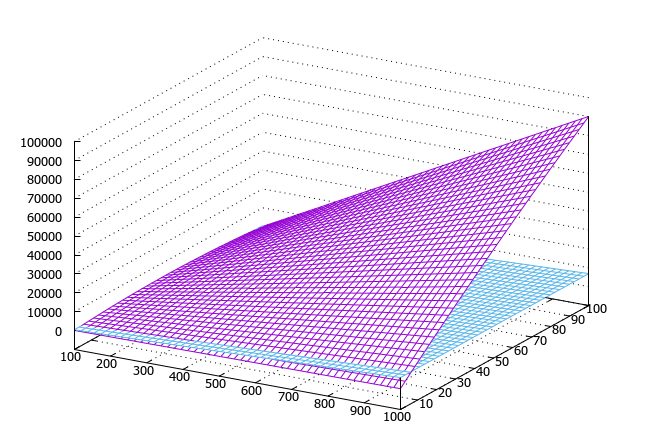

In [25]:
%pylab inline
from IPython import display
display.Image("compexitys.png")

Here the blue plain shows fft algorithm and ping regular one. x axis - kernal size, y - sample, z - function value.     
As we can see regular convolution a little bit faster only on small kernel sizes and much slower on bigger

## Task 2: Frequency Filtering with IIR Filters

### Some Theory
References:
1. https://en.wikipedia.org/wiki/Infinite_impulse_response
2. https://dspguru.com/dsp/faqs/iir/basics/
3. https://www.advsolned.com/difference-between-iir-and-fir-filters-a-practical-design-guide/
4. https://www.youtube.com/watch?v=jL_1DwUMD2w&ab_channel=PhysicsVideosbyEugeneKhutoryansky
5. https://www.youtube.com/watch?v=9yNQBWKRSs4&ab_channel=BarryVanVeen
6. https://ccrma.stanford.edu/~jos/fp/Direct_Form_II.html
---

In this section we are going to dicuss *Infinite Impulse Response*(IIR) filters. 

> Essentially IIR filters are one of the two digital filters which is needed to filter out some frequencies from the signal.

**Why IIR is infinite and FIR is not?** \
Because, IIR has a **feedback term**. In IIR each output uses previous outputs and weighted input signal.\
By that if the input signal in infinite the output signal will be nonzero too.
While, in FIR filters if filters has N coefficients the output will become zero after N terms, because there are no feedback term.[2]

**What are the advantages of IIR over FIR?** \
IIR uses **less memory** and calculations to reach same result as FIR[2]

**What are the disadvantages of IIR compared to FIR?** \
Single floating point arithmetics can induce **noise** that will be amplified each iteration[2]

1. Now let us observe the noncanonical representation of the IIR filter\
    $$
    %     y_0 = (b \cdot x_0) + (a_1 \cdot y_1) + (a_2 \cdot y_2)
    y(n) = \sum_{k=0}^{q} b_k x (n - k) - \sum_{k=1}^{p} a_k y (n - k)
    $$

    where:
    - $y(n)$ is a nth output signal value
    - $x(n)$ is a nth input signal value
    - $b_k$ is the kth term of feedforward coefficients
    - $a_k$ is the kth term of feedback coefficients


2. In order to speed up computations canonical representations is used:

    **Direct Form II**[6]
    $$
    v(n) = x(n) - a_1 v(n-1) - a_2 v(n-2)
    $$
    $$
    y(n) = b_0 v(n) + b_1 v(n - 1) + b_2 v(n-2)
    $$
    
    where:
    - $x(n)$ is the nth term of the signal
    - $y(n)$ is the nth term of the output signal
    - $v(n)$ is the nth term of delay
    - $a_1, a_2$ are feedback coefficients
    - $b_0, b_1, b_2$ are feedforward coefficients

### Implement IIR filter

To implement IIR we will need to have one memory buffer and two sets of coefficients.\
Memory buffer will store all the calculated values of output signal\
At each step we will refer to memory buffer and retrieve last values\
and use them to calculate next value

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.io import wavfile

from numba import jit

In the following cell we will write **noncanonical** IIR filter implementation

In [2]:
def IIR_filter(a, b: np.array):
    '''
    Returns a filter with given coefficients
    
    :param a - np.array with coefficients
    :param b - np.array with coefficients
    
    :returns function
    '''
    p = len(a)
    q = len(b)
    
    # we will need reversed coefficients
    # and numba works better with contiguous arrays
    a_reverse = np.ascontiguousarray(a[::-1])
    b_reverse = np.ascontiguousarray(b[::-1])
    
    # use numba's decorator to speed up calculations(on average about 2s improvement)
    @jit
    def func(signal: np.array) -> np.array:
        '''
        Returns filtered signal
        
        :param signal - np.array values of the signal
        
        :returns filtered signal
        '''
        # prepend zeroes to the signal
        shift = max(p, q)
        zeros = np.zeros(shift)
        signal = np.concatenate((zeros, signal))  # np.insert(signal, 0, zeros, axis=0)
        
        # append zero terms to the output
        output = zeros.copy()

        for n, xn in enumerate(signal):
            # ignore zero terms
            if n < shift:
                continue
            # @ symbol in numpy refers to dot/matrix product
            feedforward = b_reverse @ signal[n - q: n]
            feedback = a_reverse @ output[n - p: n]
            
            yn = feedforward + feedback
            yn = np.array([yn])
            
            output = np.append(output, yn, axis=0)
        return output[3:]  # remove previously appended zero terms
    
    return func

In the following cell we will write **canonical** IIR filter implementation

In the canonical implementation, we will have one memory buffer for storing z delays\
And one storage for output signal values

In [3]:
def IIR_filter(a, b: np.array):
    '''
    Returns a filter with given coefficients
    
    :param a - np.array with coefficients
    :param b - np.array with coefficients
    
    :returns function
    '''
    p = len(a)
    q = len(b)
    
    # we will need reversed coefficients
    # and numba works better with contiguous arrays
    a_reverse = np.ascontiguousarray(a[::-1])
    b_reverse = np.ascontiguousarray(b[::-1])
    
    # use numba's decorator to speed up calculations(on average about 2s improvement)
    @jit
    def func(signal: np.array) -> np.array:
        '''
        Returns filtered signal
        
        :param signal - np.array values of the signal
        
        :returns filtered signal
        '''
        # prepend zeroes to the signal
        shift = max(p, q)
        zeros = np.zeros(shift)
        signal = np.concatenate((zeros, signal))
        
        output = []
        delays = list(np.zeros(shift))
    
#         breakpoint()
        for n, xn in enumerate(signal):
            # ignore zero terms
            if n < shift:
                continue
            # @ symbol in numpy refers to dot/matrix product
            delay_n = xn + a_reverse @ np.array(delays[-p:], dtype='float64')
            delay_n_np = np.array(delays[-q:], dtype='float64')
            
            delays.append(delay_n)
            
            yn = b_reverse @ delay_n_np            
            output.append(yn)
            
        return output

    return func

### Create and Apply filters

In [4]:
audio = 'DSP_2020_A3_DATA/music_20s_8000.wav'
fs, ex_signal = wavfile.read(audio)

Let us take sample audio file

Audio includes sound of different musical instruments

Audio can be listened in the next cell\
The Spectogram is also provided

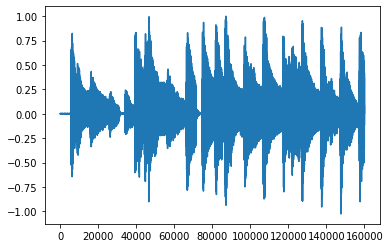

In [5]:
plt.plot(ex_signal)
plt.show()

Audio(ex_signal,rate=fs)

#### Lowpass Filter

In this section we will create and apply lowpass filter

Lowpass filter removes high frequencies from the signal and keeps low\
Changing coefficients will change threshold of the filter

In [6]:
# Lowpass, starts cutting frequencies after 20Hz
# Better to listen in your headphones
a = [1.9733442497812987,
     -0.9736948719763]# coefficients for a_1 and a_2
b = [0.00008765554875401547,
     0.00017531109750803094,
     0.00008765554875401547] # coefficients for b_0, b_1 and b_2

# create lowpass filter with given coefficients
lowpass_filter = IIR_filter(np.array(a), np.array(b))

We will apply lowpass filter

In [7]:
%%time
filtered_signal_low = lowpass_filter(ex_signal)

CPU times: user 1.11 s, sys: 111 ms, total: 1.22 s
Wall time: 1.08 s


Visually we can see waves with higher frequency disappeared from the graph\
and only low frequency left

We can hear only bass sounds properly\
Difficult to recognize piano in the background

In [ ]:
plt.plot(filtered_signal_low)
plt.title("Lowpass filter result")
plt.ylabel("Amplitude")
plt.xlabel("Samples")
plt.show()

Audio(filtered_signal_low,rate=fs)

#### Highpass Filter

In this section we are going to apply highpass filter

Highpass filter removes low frequencies from the signal and keeps high\
Changing coefficients will change threshold of the filter

In [8]:
# Highpass, starts passing frequencies after 3kHz
a = [-0.3769782747249014,
     -0.19680764477614976] # coefficients for a_1 and a_2
b = [0.40495734254626874,
     -0.8099146850925375,
     0.4049573425462687] # coefficients for b_0, b_1 and b_2

# create highpass filter wih given coefficients
highpass_filter = IIR_filter(a, b)

We will apply highpass filter on our signal

Visally, in the spectogram only frequent ticks left\
We cannot hear bass sounds clearly

In [9]:
%%time
filtered_signal_high = highpass_filter(ex_signal)

CPU times: user 633 ms, sys: 7.22 ms, total: 640 ms
Wall time: 651 ms


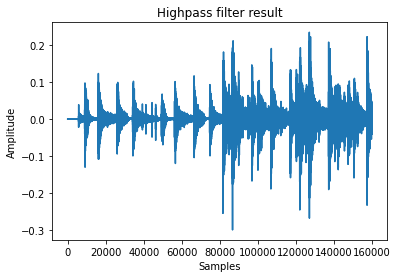

In [10]:
plt.plot(filtered_signal_high)

plt.title("Highpass filter result")
plt.ylabel("Amplitude")
plt.xlabel("Samples")
plt.show()

Audio(filtered_signal_high,rate=fs)

### Verify results

In this section we are going to actually verify that the filters did work

For that we are going to compute the approximate DFT spectrum of these IIR filters

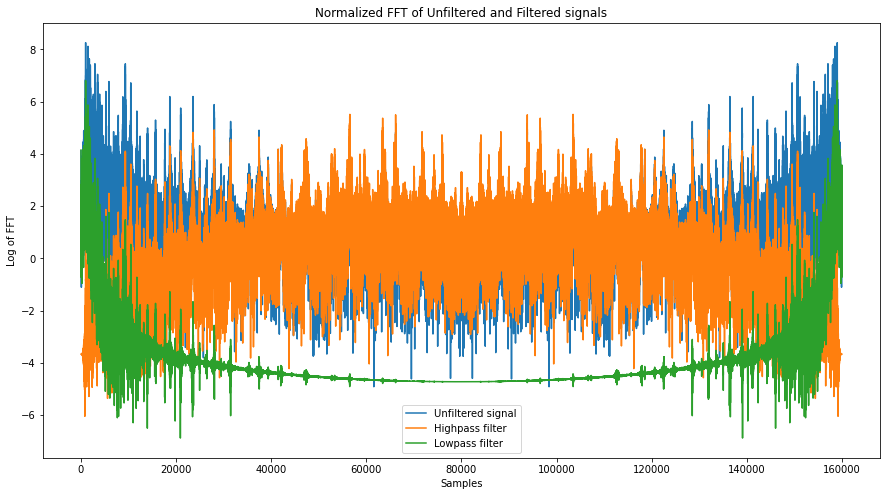

In [11]:
# N = 1e8
plt.figure(figsize=(15, 8))
plt.plot(np.log(np.abs(np.fft.fft(ex_signal))), label="Unfiltered signal")
plt.plot(np.log(np.abs(np.fft.fft(filtered_signal_high))), label="Highpass filter")
plt.plot(np.log(np.abs(np.fft.fft(filtered_signal_low))), label="Lowpass filter")

plt.title("Normalized FFT of Unfiltered and Filtered signals")
plt.ylabel("Log of FFT")
plt.xlabel("Samples")

plt.legend()

plt.show()

#### DFT of Lowpass Filter Result

Left graph shows overall FFT result, center graph shows FFT in range \[0kHz, 2kHz\] and right graph shows FFT in range \[2kHz, 80kHz\]\
As you can see low pass filter removed all frequencies after **2kHz**

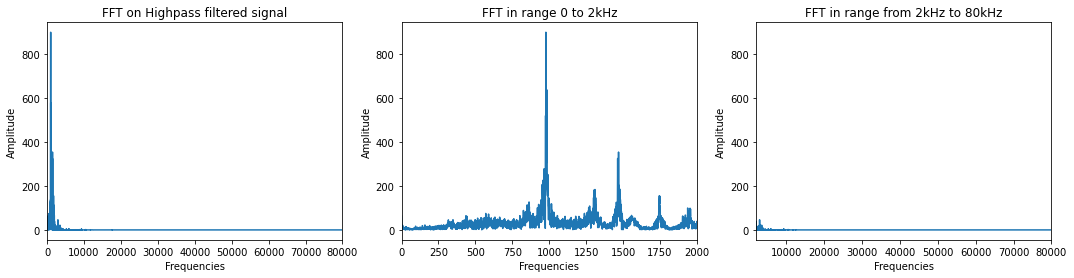

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))

ax1.plot(np.abs(np.fft.fft(filtered_signal_low)))
ax2.plot(np.abs(np.fft.fft(filtered_signal_low)))
ax3.plot(np.abs(np.fft.fft(filtered_signal_low)))

ax1.set_xlim([0, 80000])
ax2.set_xlim([0, 2000])
ax3.set_xlim([2000, 80000])

ax1.set_title("FFT on Highpass filtered signal")
ax2.set_title("FFT in range 0 to 2kHz")
ax3.set_title("FFT in range from 2kHz to 80kHz")

ax1.set_ylabel("Amplitude")
ax2.set_ylabel("Amplitude")
ax3.set_ylabel("Amplitude")

ax1.set_xlabel("Frequencies")
ax2.set_xlabel("Frequencies")
ax3.set_xlabel("Frequencies")

plt.show()

#### DFT of Highpass Filter Result

Left graph shows overall FFT result, center graph shows FFT in range \[0kHz, 3kHz\] and right graph shows FFT in range \[3kHz, 80kHz\]\
As you can see high pass filter removed all frequencies before **3kHz**

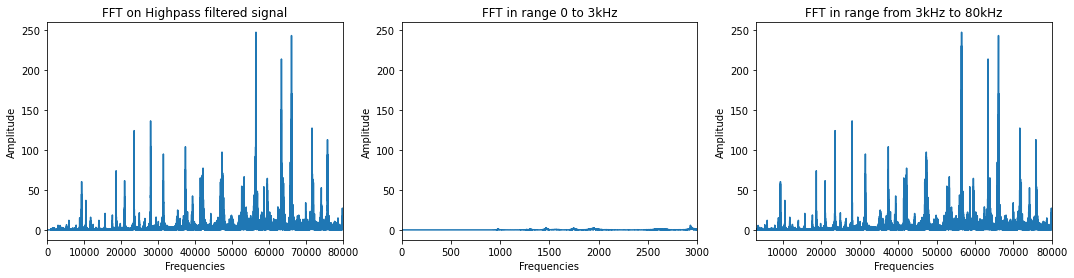

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))

ax1.plot(np.abs(np.fft.fft(filtered_signal_high)))
ax2.plot(np.abs(np.fft.fft(filtered_signal_high)))
ax3.plot(np.abs(np.fft.fft(filtered_signal_high)))

ax1.set_xlim([0, 80000])
ax2.set_xlim([0, 3000])
ax3.set_xlim([3000, 80000])

ax1.set_title("FFT on Highpass filtered signal")
ax2.set_title("FFT in range 0 to 3kHz")
ax3.set_title("FFT in range from 3kHz to 80kHz")

ax1.set_ylabel("Amplitude")
ax2.set_ylabel("Amplitude")
ax3.set_ylabel("Amplitude")

ax1.set_xlabel("Frequencies")
ax2.set_xlabel("Frequencies")
ax3.set_xlabel("Frequencies")

plt.show()